In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as Imbpipeline
from sklearn.pipeline import Pipeline


In [2]:
# Import data
add_features=pd.read_csv('https://drive.google.com/uc?id=197G_ECGO8jQUQiaHFyVmBayz31NRKppX')
basic_features=pd.read_csv('https://drive.google.com/uc?id=1tw6Icqirk3LCm9wibybBQU3znhVvs2WU')
content_features=pd.read_csv('https://drive.google.com/uc?id=1G4vyxXnOszbKIbAtwhBOyh4r9GxPwwQY')
flow_features=pd.read_csv('https://drive.google.com/uc?id=1WJPAohuba5Er-JpH075OFp7NoxdoNOgc')
label_features=pd.read_csv('https://drive.google.com/uc?id=1wQ6Q8zlxjH-eDfhnCR6I1o-bos07diJf')
time_features=pd.read_csv('https://drive.google.com/uc?id=1Zf7BjEHGaDO6mPFTcH3ExWr3IAgbYcVw')

In [3]:
list_features=[add_features,basic_features,content_features,flow_features,time_features,label_features]
for features in list_features:
    features=pd.DataFrame(features)

df_train=add_features
list_features=[basic_features,content_features,flow_features,time_features,label_features]
for features in list_features:
    df_train=pd.merge(df_train,features,on='id')

df_train.drop(['label','id'],axis=1,inplace=True)
df_train.head(5)

,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,...,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat,attack_cat
0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,5.0,4.0,2.0,...,0.0,tcp,4449.110313,3234.831566,11.845558,6.261361,NaN,0.000444,0.000114,Normal
1,0.0,2.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,NaN,...,0.0,udp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,NaN,Generic
2,0.0,NaN,0.0,0.0,0.0,4.0,4.0,2.0,2.0,1.0,...,0.0,tcp,8561.040438,249.950547,165.386453,172.345750,0.158826,0.057902,0.100924,Exploits
3,0.0,0.0,0.0,0.0,0.0,9.0,9.0,3.0,2.0,2.0,...,0.0,tcp,4053.086020,2918.730804,8.669644,4.496707,0.000558,0.000448,NaN,Normal
4,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,3.0,1.0,...,0.0,udp,0.000000,0.000000,0.008000,0.007000,0.000000,0.000000,0.000000,Normal


In [4]:
df_train['is_sm_ips_ports']=df_train['is_sm_ips_ports'].astype('object')
df_train['is_ftp_login']=df_train['is_ftp_login'].astype('object')

In [5]:
df_train.dtypes

is_sm_ips_ports       object
ct_state_ttl         float64
ct_flw_http_mthd     float64
is_ftp_login          object
ct_ftp_cmd           float64
ct_srv_src           float64
ct_srv_dst           float64
ct_dst_ltm           float64
ct_src_ltm           float64
ct_src_dport_ltm     float64
ct_dst_sport_ltm     float64
ct_dst_src_ltm       float64
state                 object
dur                  float64
sbytes               float64
dbytes               float64
sttl                 float64
dttl                 float64
sloss                float64
dloss                float64
service               object
sload                float64
dload                float64
spkts                float64
dpkts                float64
swin                 float64
dwin                 float64
stcpb                float64
dtcpb                float64
smean                float64
dmean                float64
trans_depth          float64
response_body_len    float64
proto                 object
sjit          

# EDA

In [6]:
# Size of the data
print("Numbers of instances :",df_train.shape[0],"and","Numbers of features : ",
df_train.shape[1])

Numbers of instances : 175341 and Numbers of features :  42


In [7]:
# Show dtypes all features
categorical_features = df_train.select_dtypes(include='O').columns
numerical_features = df_train.select_dtypes(include=['int', 'float']).columns
print("Categorical Features:")
print(", ".join(categorical_features) if not categorical_features.empty else "None")

print("\nNumerical Features:")
print(", ".join(numerical_features) if not numerical_features.empty else "None")

Categorical Features:
is_sm_ips_ports, is_ftp_login, state, service, proto, attack_cat

Numerical Features:
ct_state_ttl, ct_flw_http_mthd, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, dur, sbytes, dbytes, sttl, dttl, sloss, dloss, sload, dload, spkts, dpkts, swin, dwin, stcpb, dtcpb, smean, dmean, trans_depth, response_body_len, sjit, djit, sinpkt, dinpkt, tcprtt, synack, ackdat


In [8]:
# Checking missing values
df_train.isnull().sum()

is_sm_ips_ports      8746
ct_state_ttl         8635
ct_flw_http_mthd     8647
is_ftp_login         8647
ct_ftp_cmd           8842
ct_srv_src           8851
ct_srv_dst           8774
ct_dst_ltm           8738
ct_src_ltm           8823
ct_src_dport_ltm     8775
ct_dst_sport_ltm     8788
ct_dst_src_ltm       8895
state                8805
dur                  8722
sbytes               8561
dbytes               8869
sttl                 8825
dttl                 8654
sloss                8794
dloss                8978
service              8791
sload                8786
dload                8837
spkts                8654
dpkts                8686
swin                 8740
dwin                 8779
stcpb                8672
dtcpb                8803
smean                8788
dmean                8855
trans_depth          8785
response_body_len    8791
proto                8826
sjit                 8738
djit                 8846
sinpkt               8707
dinpkt               8734
tcprtt      

In [9]:
# Checking number of outliers
train_numeric = df_train.select_dtypes(include=['int64', 'float64'])
Q1 = train_numeric.quantile(0.25)
Q3 = train_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers = (train_numeric < (Q1 - 1.5 * IQR)) | (train_numeric > (Q3 + 1.5 * IQR))
outliers_count = outliers.sum()
print("Number of outliers in each feature:")
print(outliers_count)

Number of outliers in each feature:
ct_state_ttl          1838
ct_flw_http_mthd     16996
ct_ftp_cmd            2443
ct_srv_src           18379
ct_srv_dst           18380
ct_dst_ltm           21021
ct_src_ltm           12487
ct_src_dport_ltm     31801
ct_dst_sport_ltm     35385
ct_dst_src_ltm       16832
dur                  14968
sbytes               21760
dbytes               26698
sttl                     0
dttl                     0
sloss                10879
dloss                26996
sload                12843
dload                36132
spkts                23470
dpkts                19752
swin                     0
dwin                     0
stcpb                    0
dtcpb                    0
smean                19690
dmean                22185
trans_depth          16948
response_body_len    10723
sjit                 17146
djit                 19538
sinpkt               14034
dinpkt               13409
tcprtt               15228
synack               29934
ackdat             

In [10]:
df_train.corr(numeric_only=True)

,ct_state_ttl,ct_flw_http_mthd,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,...,dmean,trans_depth,response_body_len,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat
ct_state_ttl,1.000000,-0.097869,-0.075633,0.361170,0.364831,0.302697,0.296982,0.355013,0.393390,0.428036,...,-0.464543,-0.071958,-0.026142,-0.038057,-0.113478,0.102219,-0.041936,-0.110149,-0.100725,-0.106479
ct_flw_http_mthd,-0.097869,1.000000,-0.022825,-0.121654,-0.119239,-0.087196,-0.077356,-0.086710,-0.087125,-0.107504,...,0.130121,0.221237,0.067088,0.082934,0.100159,-0.019179,0.047421,0.165381,0.146846,0.167564
ct_ftp_cmd,-0.075633,-0.022825,1.000000,-0.090000,-0.087999,-0.048734,-0.047360,-0.064048,-0.065280,-0.063029,...,-0.024320,-0.022434,-0.004658,0.006009,0.079407,-0.014478,0.002036,0.067564,0.057001,0.071685
ct_srv_src,0.361170,-0.121654,-0.090000,1.000000,0.980276,0.841289,0.780664,0.865623,0.822883,0.966881,...,-0.225076,-0.089456,-0.027172,-0.045601,-0.081666,-0.090113,-0.042390,-0.301684,-0.275279,-0.296122
ct_srv_dst,0.364831,-0.119239,-0.087999,0.980276,1.000000,0.853150,0.778210,0.868715,0.830232,0.972186,...,-0.228374,-0.090108,-0.027115,-0.049876,-0.081089,-0.087319,-0.045295,-0.316313,-0.289530,-0.310101
ct_dst_ltm,0.302697,-0.087196,-0.048734,0.841289,0.853150,1.000000,0.885833,0.962079,0.870412,0.853042,...,-0.204035,-0.066890,-0.015934,-0.046785,-0.056824,-0.072049,-0.042717,-0.286305,-0.264306,-0.278000
ct_src_ltm,0.296982,-0.077356,-0.047360,0.780664,0.778210,0.885833,1.000000,0.897505,0.802001,0.783401,...,-0.201224,-0.071823,-0.017697,-0.045041,-0.062575,-0.081309,-0.042205,-0.278263,-0.257473,-0.269658
ct_src_dport_ltm,0.355013,-0.086710,-0.064048,0.865623,0.868715,0.962079,0.897505,1.000000,0.906812,0.869791,...,-0.244948,-0.076053,-0.020219,-0.044040,-0.071223,-0.061102,-0.038635,-0.264175,-0.243742,-0.256283
ct_dst_sport_ltm,0.393390,-0.087125,-0.065280,0.822883,0.830232,0.870412,0.802001,0.906812,1.000000,0.838791,...,-0.263875,-0.071003,-0.021754,-0.045666,-0.075892,-0.057769,-0.039612,-0.279442,-0.259282,-0.269742
ct_dst_src_ltm,0.428036,-0.107504,-0.063029,0.966881,0.972186,0.853042,0.783401,0.869791,0.838791,1.000000,...,-0.279877,-0.081667,-0.021167,-0.047454,-0.081533,-0.081389,-0.042924,-0.290443,-0.266942,-0.284228


In [11]:
# Check duplicated and remove
df_train.duplicated().sum()

5756

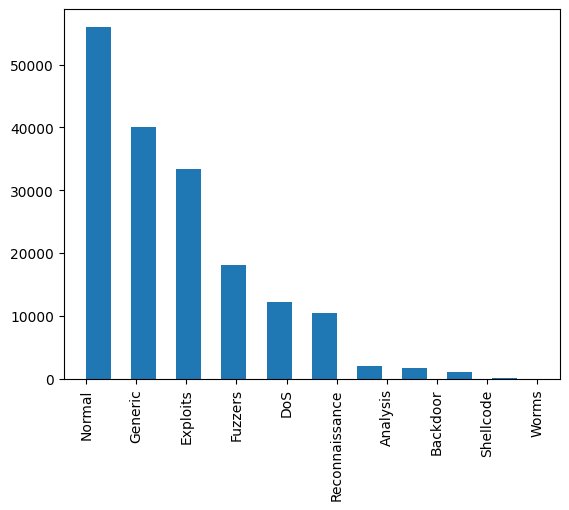

'Data belum seimbang untuk setiap label'

In [12]:
# Check distribution of label
plt.hist(df_train['attack_cat'], width=0.5)
plt.xticks(rotation=90)
plt.show()

"Data belum seimbang untuk setiap label"

In [13]:
df_train

,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,...,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat,attack_cat
0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,5.0,4.0,2.0,...,0.0,tcp,4449.110313,3234.831566,11.845558,6.261361,NaN,0.000444,0.000114,Normal
1,0.0,2.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,NaN,...,0.0,udp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,NaN,Generic
2,0.0,NaN,0.0,0.0,0.0,4.0,4.0,2.0,2.0,1.0,...,0.0,tcp,8561.040438,249.950547,165.386453,172.345750,0.158826,0.057902,0.100924,Exploits
3,0.0,0.0,0.0,0.0,0.0,9.0,9.0,3.0,2.0,2.0,...,0.0,tcp,4053.086020,2918.730804,8.669644,4.496707,0.000558,0.000448,NaN,Normal
4,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,3.0,1.0,...,0.0,udp,0.000000,0.000000,0.008000,0.007000,0.000000,0.000000,0.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.0,2.0,0.0,0.0,0.0,38.0,38.0,32.0,NaN,32.0,...,0.0,udp,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,0.000000,Generic
175337,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,NaN,...,NaN,tcp,15464.286700,531.848125,193.445428,209.600766,0.066524,0.047738,0.018786,Exploits
175338,0.0,2.0,0.0,NaN,0.0,33.0,33.0,16.0,16.0,16.0,...,0.0,udp,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,Generic
175339,0.0,2.0,0.0,0.0,0.0,36.0,36.0,NaN,37.0,36.0,...,0.0,udp,0.000000,0.000000,0.004000,0.000000,0.000000,0.000000,NaN,Generic


# Data Preparation

In [14]:
X=df_train.drop('attack_cat',axis=1)
y=df_train['attack_cat']

In [15]:
X.shape, y.shape

((175341, 41), (175341,))

In [16]:
X_train,X_val,y_train,y_val=train_test_split(X,y, test_size=0.2, random_state=42)

In [17]:
num_features=X_train.select_dtypes(include='number').columns
cat_features=X_train.select_dtypes(include='O').columns

In [18]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),# Fill missing values with mean
    ('scaler', MinMaxScaler()), #Standardize numerical features
    
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),# One-hot encode
    ('feature_selection', SelectKBest(score_func=chi2, k=4))# Fill missing values with mode
    
])

In [19]:
Preparation = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEncoder(BaseEstimator, TransformerMixin):

     def fit(self, X, y=None):

         # Fit the encoder here

         return self

     def transform(self, X):
         X_encoded = X.copy()

         # Encode the categorical variables here

         return X_encoded

In [21]:
X_trf=Preparation.fit_transform(X_train,y_train)

In [22]:
X_trf.shape

(140272, 14)

In [23]:
ADS = ADASYN()
X_res, y_res = ADS.fit_resample(X_trf, y_train)

In [24]:
y_res.value_counts()

attack_cat
Reconnaissance    45659
Fuzzers           45459
Exploits          45183
Backdoor          44912
Worms             44754
Normal            44746
Generic           44520
Shellcode         44496
Analysis          44429
DoS               43237
Name: count, dtype: int64

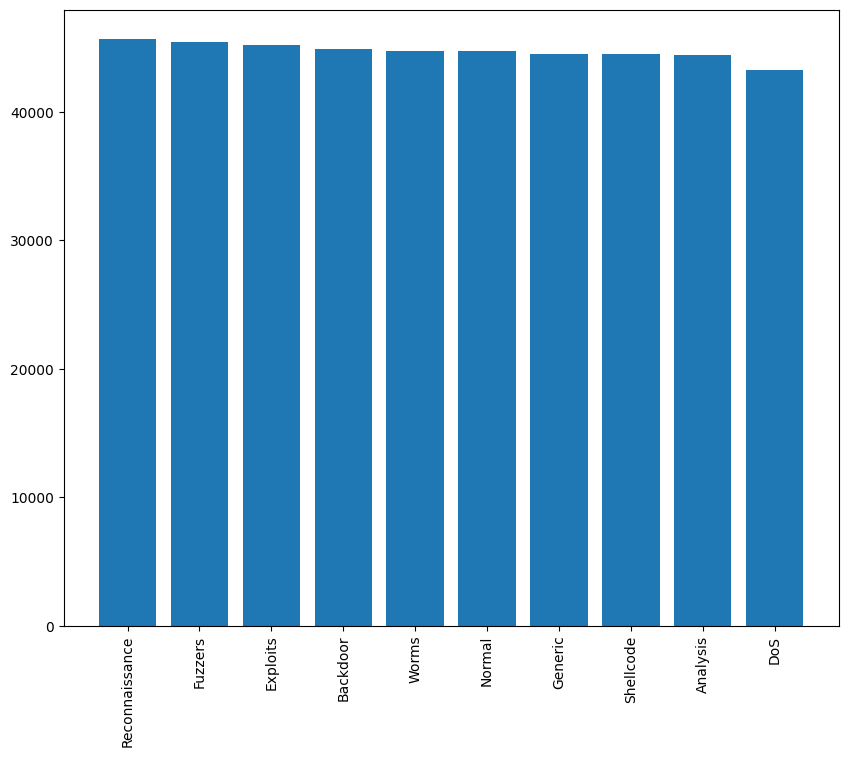

In [25]:
plt.figure(figsize=(10, 8))
value_counts = y_res.value_counts()  # Calculate value counts
plt.bar(value_counts.index, value_counts.values, width=0.8)  # Pass index and values
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()


In [26]:
y_res.value_counts()

attack_cat
Reconnaissance    45659
Fuzzers           45459
Exploits          45183
Backdoor          44912
Worms             44754
Normal            44746
Generic           44520
Shellcode         44496
Analysis          44429
DoS               43237
Name: count, dtype: int64

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_pipeline = Imbpipeline(steps=[
    ('Preparation', Preparation),
    ('Balancing', ADASYN()),
    ('knn', KNeighborsClassifier(n_neighbors=7, metric='minkowski')) 
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn_pipeline.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of KNN model: {accuracy:.4f}")

Accuracy of KNN model: 0.7409


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_pipeline = Imbpipeline(steps=[
    ('Preparation', Preparation),
    ('Balancing', ADASYN()),
    ('knn', KNeighborsClassifier(n_neighbors=7, metric='manhattan', p=1)) 
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn_pipeline.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of KNN model: {accuracy:.4f}")

Accuracy of KNN model: 0.7471


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_pipeline = Imbpipeline(steps=[
    ('Preparation', Preparation),
    ('Balancing', ADASYN()),
    ('knn', KNeighborsClassifier(n_neighbors=7, metric='euclidean', p=2)) 
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn_pipeline.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of KNN model: {accuracy:.4f}")

Accuracy of KNN model: 0.7422


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                precision    recall  f1-score   support

      Analysis       0.15      0.17      0.16       384
      Backdoor       0.09      0.06      0.07       367
           DoS       0.32      0.35      0.33      2459
      Exploits       0.62      0.68      0.65      6636
       Fuzzers       0.57      0.60      0.59      3637
       Generic       0.99      0.98      0.98      7975
        Normal       0.93      0.85      0.89     11254
Reconnaissance       0.47      0.48      0.47      2070
     Shellcode       0.06      0.05      0.05       259
         Worms       0.06      0.11      0.08        28

      accuracy                           0.74     35069
     macro avg       0.43      0.43      0.43     35069
  weighted avg       0.75      0.74      0.75     35069



In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Replace KNeighborsClassifier with GaussianNB
nb_pipeline = Imbpipeline(steps=[
    ('Preparation', Preparation),  # Assuming this is your custom preprocessing step
    ('Balancing', ADASYN()),       # Data balancing using ADASYN
    ('naive_bayes', GaussianNB())  # Use Gaussian Naive Bayes
])

# Fit the pipeline to the training data
nb_pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = nb_pipeline.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of Naive Bayes model: {accuracy:.4f}")

Accuracy of Naive Bayes model: 0.3121


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import ADASYN  # Balancing method

# Replace GaussianNB with DecisionTreeClassifier
dt_pipeline = Imbpipeline(steps=[
    ('Preparation', Preparation),  # Assuming this is your custom preprocessing step
    ('Balancing', ADASYN()),       # Data balancing using ADASYN
    ('decision_tree', DecisionTreeClassifier(criterion='entropy', random_state=42))  # Decision Tree Classifier
])

# Fit the pipeline to the training data
dt_pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = dt_pipeline.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of Decision Tree model: {accuracy:.4f}")


Accuracy of Decision Tree model: 0.6969


## Model from Scratch

### Naive Bayes

In [33]:
import math
import random

def encode_class(mydata):
    classes = []
    for i in range(len(mydata)):
        if mydata[i][-1] not in classes:
            classes.append(mydata[i][-1])
    for i in range(len(classes)):
        for j in range(len(mydata)):
            if mydata[j][-1] == classes[i]:
                mydata[j][-1] = i
    return mydata

def splitting(mydata, ratio):
    train_num = int(len(mydata) * ratio)
    train = []
    test = list(mydata)
    while len(train) < train_num:
        index = random.randrange(len(test))
        train.append(test.pop(index))
    return train, test

def groupUnderClass(mydata):
    data_dict = {}
    for i in range(len(mydata)):
        if mydata[i][-1] not in data_dict:
            data_dict[mydata[i][-1]] = []
        data_dict[mydata[i][-1]].append(mydata[i])
    return data_dict

def MeanAndStdDev(numbers):
    avg = np.mean(numbers)
    stddev = np.std(numbers)
    return avg, stddev

def MeanAndStdDevForClass(mydata):
    info = {}
    data_dict = groupUnderClass(mydata)
    for classValue, instances in data_dict.items():
        info[classValue] = [MeanAndStdDev(attribute) for attribute in zip(*instances)]
    return info

def calculateGaussianProbability(x, mean, stdev):
    epsilon = 1e-10
    expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev + epsilon, 2))))
    return (1 / (math.sqrt(2 * math.pi) * (stdev + epsilon))) * expo

def calculateClassProbabilities(info, test):
    probabilities = {}
    for classValue, classSummaries in info.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, std_dev = classSummaries[i]
            x = test[i]
            probabilities[classValue] *= calculateGaussianProbability(x, mean, std_dev)
    return probabilities

def predict(info, test):
    probabilities = calculateClassProbabilities(info, test)
    bestLabel = max(probabilities, key=probabilities.get)
    return bestLabel

def getPredictions(info, test):
    predictions = [predict(info, instance) for instance in test]
    return predictions

def accuracy_rate(test, predictions):
    correct = sum(1 for i in range(len(test)) if test[i][-1] == predictions[i])
    return (correct / float(len(test))) * 100.0

In [49]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(data):
    data = np.array(data)  # Ensure it's a NumPy array
    n_cols = data.shape[1]
    encoders = {}  # Store encoders for each column
    for col in range(n_cols):  # Skip the last column (target)
        # Check if the column contains non-numeric data
        if not np.issubdtype(data[:, col].dtype, np.number):
            # Perform label encoding on categorical column
            encoder = LabelEncoder()
            data[:, col] = encoder.fit_transform(data[:, col])
            encoders[col] = encoder
    return data.astype(float), encoders

In [50]:
# Convert df_train to numpy and preprocess
mydata = df_train.to_numpy()

# Encode categorical columns
mydata, column_encoders = encode_categorical_columns(mydata)

# Encode the target class
mydata = encode_class(mydata)

# Split the data into training and testing sets
ratio = 0.7
train_data, test_data = splitting(mydata, ratio)

print('Total number of examples:', len(mydata))
print('Training examples:', len(train_data))
print('Test examples:', len(test_data))

# Train the model
info = MeanAndStdDevForClass(train_data)

# Test the model
predictions = getPredictions(info, test_data)
accuracy = accuracy_rate(test_data, predictions)
print('Accuracy of the model:', accuracy)

Total number of examples: 175341
Training examples: 122738
Test examples: 52603
Accuracy of the model: 100.0


NameError: name 'X_train' is not defined